## Import required Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

## Load data

In [2]:
# X_train = np.load('../data/X_train.npy', allow_pickle = True)
# X_test = np.load('../data/X_test.npy', allow_pickle = True)
# y_train = np.load('../data/y_train_nohe.npy', allow_pickle = True)
# y_test = np.load('../data/y_test_nohe.npy', allow_pickle = True)
# y_train = y_train+1
# y_test = y_test+1

In [2]:
X_train = np.load('../data/X_train.npy', allow_pickle = True)
X_test = np.load('../data/X_test.npy', allow_pickle = True)
y_train = np.load('../data/y_train.npy', allow_pickle = True)
y_test = np.load('../data/y_test.npy', allow_pickle = True)
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_train: ", y_train.shape)
print("shape of Y_test: ", y_test.shape)

shape of X_train:  (122289, 1044)
shape of X_test:  (60232, 1044)
shape of Y_train:  (122289, 5)
shape of Y_test:  (60232, 5)


## Tuning

In [3]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test = sm.fit_resample(X_test, y_test)

In [10]:
# Create the random grid
random_grid = {'n_estimators': list(range(10,200,5)),
               'max_features': ['auto', 'sqrt'],
               'max_depth': list(range(2,100,2)),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4,6,8,10,20,30,40,50],
               'bootstrap': [True, False]}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2,
               4,
               6,
               8,
               10,
               12,
               14,
               16,
               18,
               20,
               22,
               24,
               26,
               28,
               30,
               32,
               34,
               36,
               38,
               40,
               42,
               44,
               46,
               48,
               50,
               52,
               54,
               56,
               58,
               60,
               62,
               64,
               66,
               68,
               70,
               72,
               74,
               76,
               78,
               80,
               82,
               84,
               86,
               88,
               90,
               92,
               94,
               96,
               98],
 'max_features': ['auto', 'sqrt'],
 'min_sa

In [15]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model



In [16]:
%%time
rf_random.fit(X_train[:1000], y_train[:1000])

NameError: name 'X_train' is not defined

In [ ]:
score_df = pd.DataFrame(rf_random.cv_results_)
score_df.sort_values(by=['rank_test_score'], ascending=True).head()

## Train the model

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [8]:
# # Instantiate model with 500 decision trees
# rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
# rf.fit(X_train, y_train)
# rf

RandomForestRegressor(n_estimators=50, random_state=42)

In [11]:
clf = RandomForestClassifier(max_depth=100, random_state=42)
clf.fit(X_train, y_train)
clf

RandomForestClassifier(max_depth=100, random_state=42)

## predictions and evaluation

In [12]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


0.6741190355757882
              precision    recall  f1-score   support

           0       0.58      0.55      0.57     35586
           1       0.84      0.73      0.78     35586
           2       0.90      0.80      0.85     35586
           3       0.75      0.70      0.73     35586
           4       0.54      0.58      0.56     35586

   micro avg       0.71      0.67      0.69    177930
   macro avg       0.72      0.67      0.70    177930
weighted avg       0.72      0.67      0.70    177930
 samples avg       0.67      0.67      0.67    177930



c:\Users\bobmst\.conda\envs\ds310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Even the accuracy is similar to the the decision tree classifier model, the precision imporved a lot with random forest

https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

In [19]:
for i in range(50,500,50):
    print(i)

50
100
150
200
250
300
350
400
450


In [24]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tqdm(tree_depths):
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting tree on different depths
sm_tree_depths = range(1,20,2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)



100%|██████████| 10/10 [17:42<00:00, 106.28s/it]


In [26]:
sm_accuracy_scores

array([0.18526858, 0.49287821, 0.51309429, 0.66835157, 0.6935507 ,
       0.69575559, 0.72568972, 0.75018604, 0.77049582, 0.78963702])

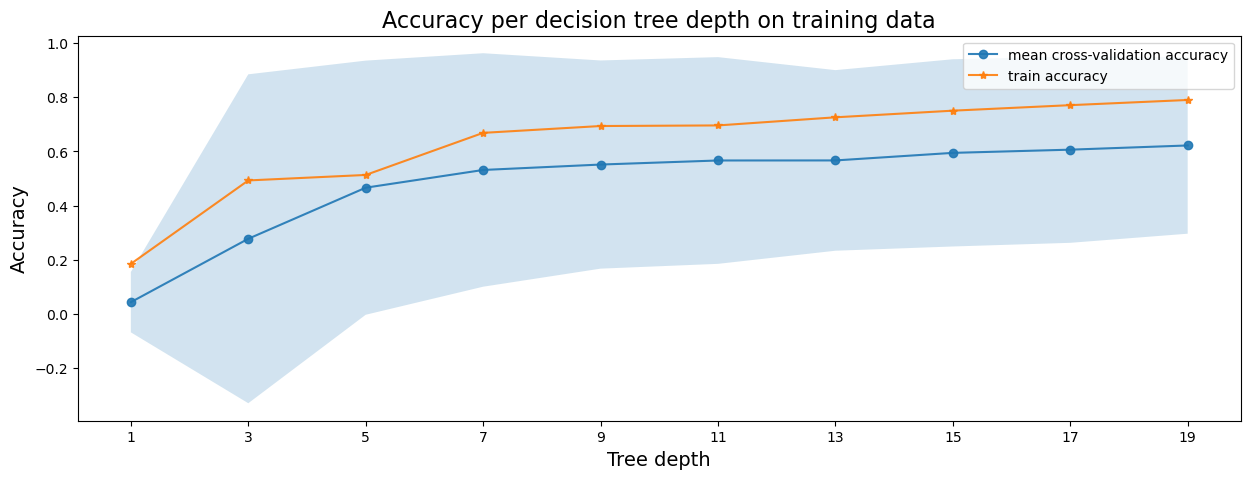

In [25]:
# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

The decisiontree's accuracy goes to 78 at depth 20. And the trend is still going up, we will try more depth now.

In [37]:
sm_tree_depths = range(20,101,20)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

100%|██████████| 5/5 [09:55<00:00, 119.13s/it]


In [39]:
sm_accuracy_scores

array([0.80654301, 0.88451341, 0.89491773, 0.89527051, 0.89527051])

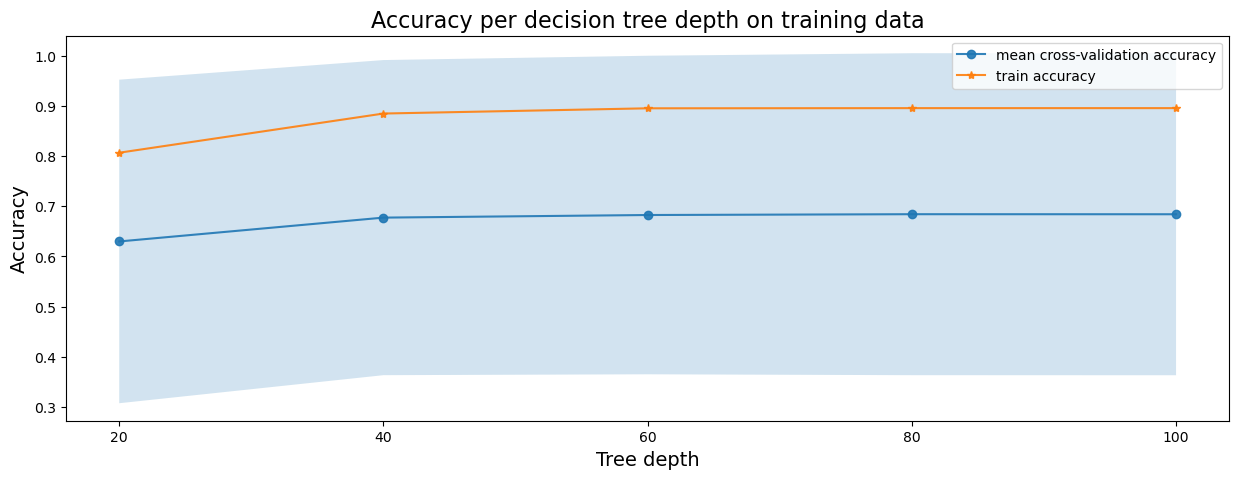

In [38]:
# plotting accuracy 
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

## finding better forest

In [50]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_forest(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tqdm(tree_depths):
        model = RandomForestClassifier(max_depth=depth, random_state=42)
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [41]:
sm_forest_depths = [1,5,10,20,30,40,50,100,200,]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X_train, y_train, sm_forest_depths)

100%|██████████| 9/9 [2:02:53<00:00, 819.28s/it] 


In [48]:
sm_cv_scores_mean

array([0.        , 0.07290191, 0.24907808, 0.47482843, 0.59876526,
       0.64550892, 0.66240388, 0.69687181, 0.70014056])

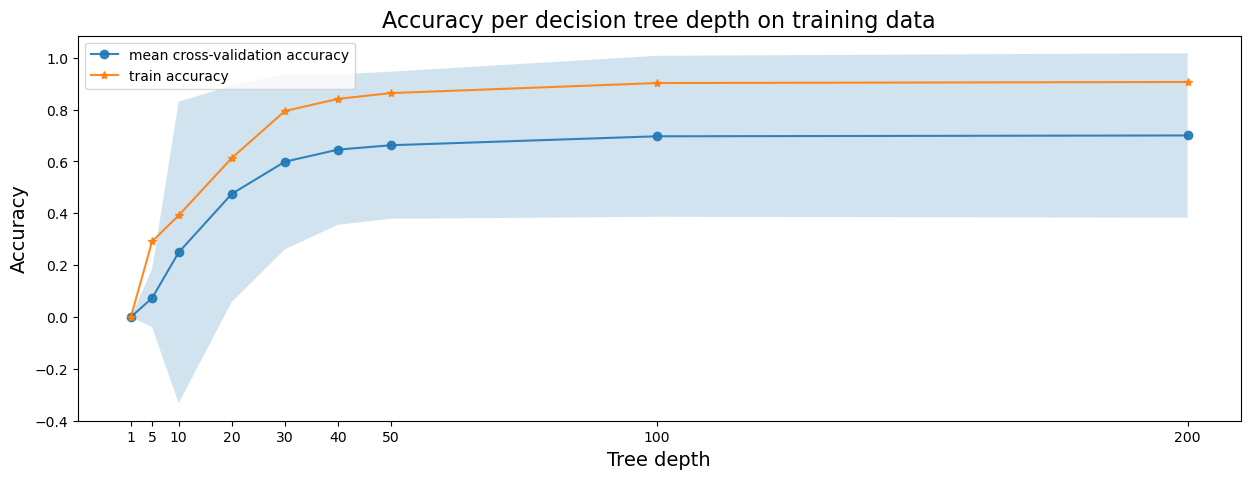

In [45]:
# plotting accuracy
plot_cross_validation_on_trees(sm_forest_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [51]:
sm_forest_depths = [60,70,80]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X_train, y_train, sm_forest_depths)
# plotting accuracy
plot_cross_validation_on_trees(sm_forest_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

 33%|███▎      | 1/3 [44:24<1:28:49, 2664.83s/it]


KeyboardInterrupt: 

In [28]:
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
matrix

array([[21368,  2141,  1431,  2466,  8180],
       [ 5674, 25906,   281,   988,  2737],
       [ 3999,    73, 28591,  1321,  1602],
       [ 3898,   734,   442, 25057,  5455],
       [ 8510,  2100,   865,  3405, 20706]], dtype=int64)

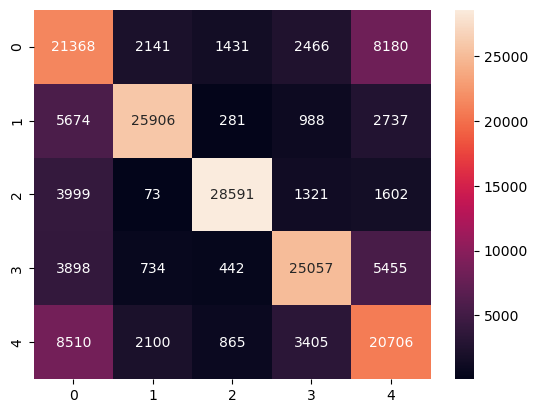

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(matrix, annot = True, fmt = 'd')
plt.show()